In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL
from sklearn.impute import KNNImputer
import seaborn as sns

sns.set_style("darkgrid")

In [2]:
# Set the random seed for reproducibility
np.random.seed(0)

# Define the start date
start_date = datetime(2022, 1, 1)

# Generate dates for 365 days
dates = [start_date + timedelta(days=i) for i in range(365)]

Our dataset comprises daily data spanning one year, featuring two variables: **sales** and **ad_spent**. Approximately $25 \%$ of the sales data contains missing values, which appear randomly and, in some cases, constitute complete gaps in the data. On the other hand, the ad_spent feature is devoid of any missing values. A notable correlation of about 66% exists between ad_spent and sales.

In [4]:
# Generate more pronounced trend component (increasing linearly)
trend = np.power(np.linspace(0.1, 20, 365), 2)

# Generate more pronounced seasonal component (sinusoidal pattern) with weekly period
seasonal = 50 * np.sin(np.linspace(0, 2 * np.pi * 52, 365)) # 52 weeks in a year

# Generate random noise
noise = np.random.normal(0, 5, 365)

# Combine components to generate sales data
sales = trend + seasonal + noise

In [5]:
# Create ad_spent feature
# Using a scaled version of sales and adding more noise
ad_spent = 0.2 * sales + np.random.normal(0, 30, 365)  # Increased the noise and decreased the scale factor
ad_spent = np.maximum(ad_spent, 0)  # Making sure all ad_spent values are non-negative


In [6]:
# Create a dataframe
df = pd.DataFrame(
    {
        'date': dates,
        'sales': sales,
        'ad_spent': ad_spent
    }
)

# Set the date as the index
df.set_index('date', inplace=True)

In [8]:
# Generate missing values for a larger gap
for i in range(150, 165):  # A 15-day gap
    df.iloc[i, df.columns.get_loc('sales')] = np.nan

# Randomly choose indices for missing values (not including the already missing gap)
random_indices = random.sample(list(set(range(365)) - set(range(150,165))), int(0.20 * 365))

# Add random missing values
for i in random_indices:
    df.iloc[i, df.columns.get_loc('sales')] = np.nan

,sales,ad_spent
date,,
2022-01-01,8.830262,6.593897
2022-01-02,41.116283,2.503652
2022-01-03,53.683909,0.000000
2022-01-04,32.968355,0.000000
2022-01-05,-12.254839,0.000000


% missing data in sales:  24.10958904109589


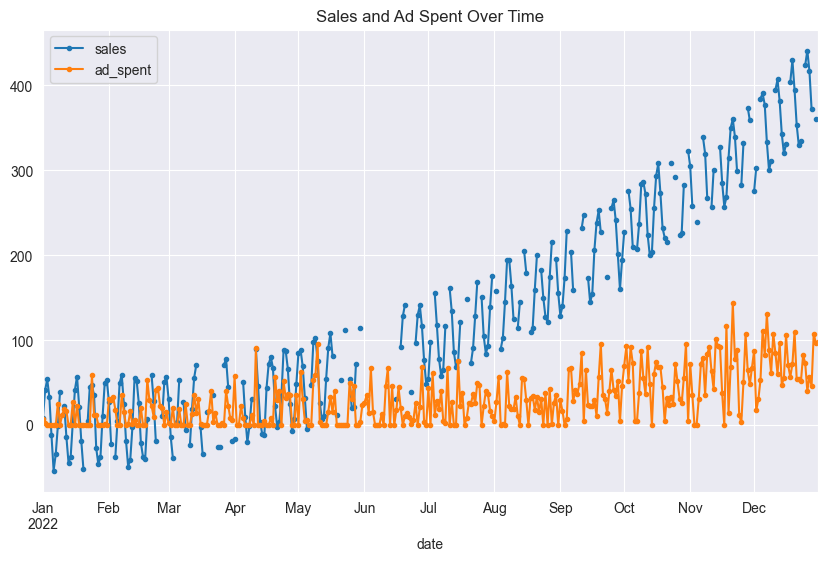

Correlation between sales and ad_spent:  0.6538148924795715


In [9]:
# Display the dataframe
display(df.head())

# Print the percentage of missing values 
print('% missing data in sales: ', 100*df['sales'].isnull().sum()/len(df))

# Plot the data
df[['sales', 'ad_spent']].plot(style='.-', figsize=(10,6), title='Sales and Ad Spent Over Time')
plt.show()

# Print correlation between sales and ad_spent
print("Correlation between sales and ad_spent: ", df['sales'].corr(df['ad_spent']))

## Basic Imputation Techniques
Here are some basic method, but it is not useful for us
- 'ffill' or 'pad' - Replace NaN s with last observed value
- 'bfill' or 'backfill' - Replace NaN s with next observed value
- Linear interpolation method

## Regression Imputation
Regression imputation is a method of imputing missing values by using the relationships between the data. In this method, a regression model is used to predict the missing values based on other data.

Regression imputation can be used when the data is numeric and there is a strong correlation between the variable with missing values and other variables.

### Impact on the Model-Building Process:
Regression imputation can lead to more accurate models by making use of the relationships between variables. However, it can also lead to an overestimate of the correlation between variables, which can affect the model’s performance.

In [10]:
# Drop missing values to fit the regression model
df_imputed = df.copy()
df_non_missing = df.dropna()

In [11]:
# Instantiate the model
model = LinearRegression()

# Reshape data for model fitting (sklearn requires 2D array for predictors)
X = df_non_missing['ad_spent'].values.reshape(-1, 1) # original shape is (277,), after reshaping it becomes (277, 1)
Y = df_non_missing['sales'].values

# Fit the model
model.fit(X, Y)

LinearRegression()

In [15]:
# Get indices of missing sales
missing_sales_indices = df_imputed[df_imputed['sales'].isnull()].index

# Predict missing sales values
predicted_sales = model.predict(df_imputed.loc[missing_sales_indices, 'ad_spent'].values.reshape(-1, 1))

# Fill missing sales with predicted values
df_imputed.loc[missing_sales_indices, 'sales'] = predicted_sales


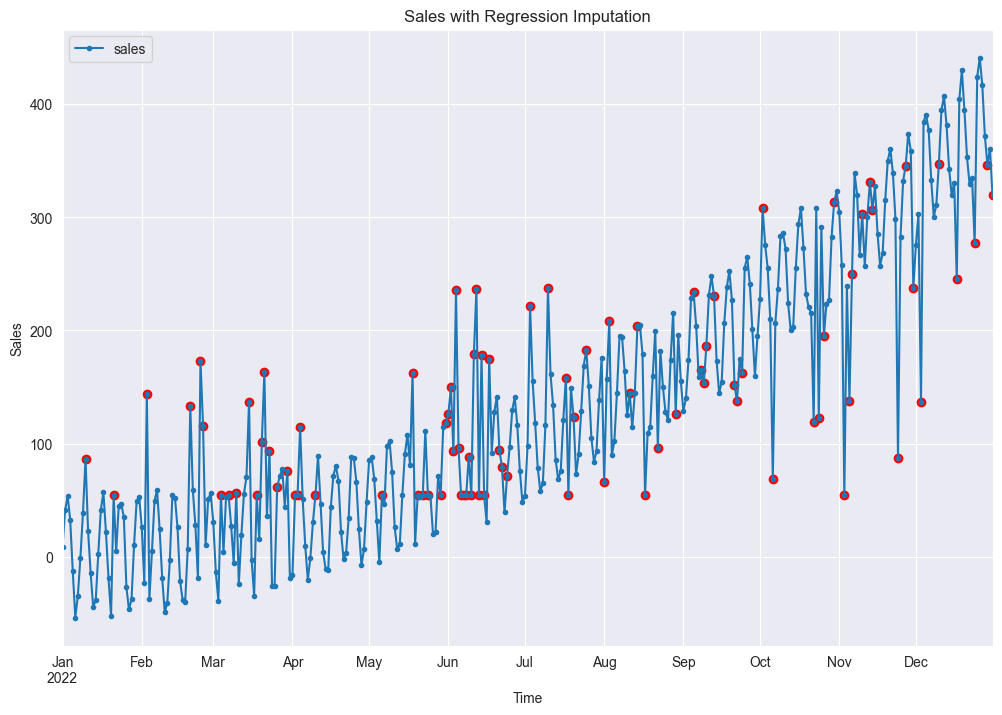

In [16]:
# Plot the main line with markers
df_imputed[['sales']].plot(style='.-', figsize=(12,8), title='Sales with Regression Imputation')

# Add points where data was imputed with red color
plt.scatter(missing_sales_indices, predicted_sales, color='red', label='Regression Imputation')

# Set labels
plt.xlabel('Time')
plt.ylabel('Sales')

plt.show()

## K-Nearest Neighbors (KNN) Imputation
KNN is a machine learning algorithm that is used for classification and regression problems. However, it can also be used for imputing missing data. The KNN imputation method works by finding the K-nearest neighbors to the observation with missing data and then imputing them based on the non-missing values in the neighbors.

KNN can be used when the data are missing at random, and the variables are almost equally important. KNN is better when the data are uniformly distributed, and it’s not suitable for high dimensional data.

### Impact on the Model-Building Process:
KNN imputation can introduce bias into the data if the missing data mechanism isn’t random. This is because the KNN algorithm relies on the assumption that similar observations exist in the dataset. If this assumption is violated, the imputed values may be far from the true values, leading to biased estimates in the model-building process.

In [17]:
# Initialize the KNN imputer with k=5
imputer = KNNImputer(n_neighbors=3)

# Apply the KNN imputer
# Note: the KNNImputer requires 2D array-like input, hence the double brackets.
df_imputed = df.copy()
df_imputed[['sales', 'ad_spent']] = imputer.fit_transform(df_imputed[['sales', 'ad_spent']])

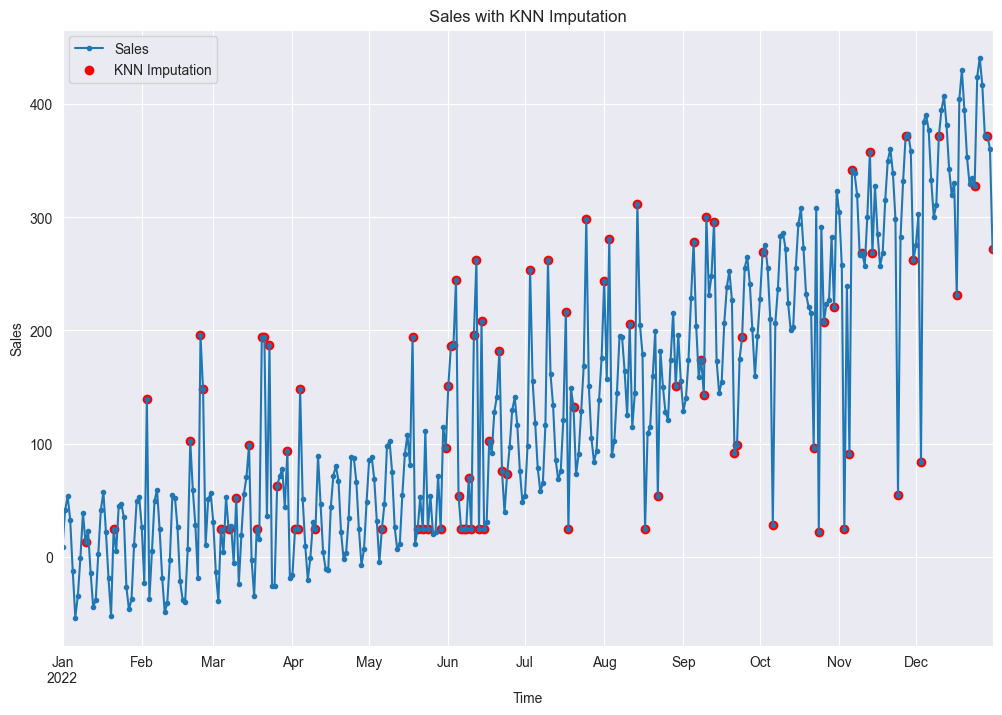

In [19]:
#Create a matplotlib plot
plt.figure(figsize=(12,8))
df_imputed['sales'].plot(style='.-', label='Sales')

# Add points where data was imputed
imputed_indices = df[df['sales'].isnull()].index
plt.scatter(imputed_indices, df_imputed.loc[imputed_indices, 'sales'], color='red', label='KNN Imputation')

# Set title and labels
plt.title('Sales with KNN Imputation')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

## Seasonal Trend Decomposition using Loess (STL) Imputation
Seasonal Trend decomposition using Loess (STL) is a statistical method for decomposing a time series into three components: trend, seasonal, and remainder (random). It can be used for imputing missing data in a time series. In the STL imputation method, the missing values are initially estimated via interpolation to allow for STL decomposition. Afterward, the seasonal and trend components of the decomposed time series are extracted. The missing values are then re-estimated by interpolating the trend component and re-adding the seasonal component.

STL imputation can be used when dealing with time series data that exhibits a seasonal pattern. It is particularly useful when the data are missing at random and the missingness is not related to the trend or seasonality of the time series.

### Impact on the Model-Building Process:
STL imputation aims to preserve the overall structure of the time series, particularly its trend and seasonal components, when filling in missing values. The imputed values are therefore more likely to reflect the actual dynamics of the time series, leading to more accurate models. However, as with any imputation method, caution should be exercised when the amount of missing data is large, as this could potentially lead to overfitting or biased results in subsequent analyses.

In [20]:
# Make a copy of the original dataframe
df_copy = df.copy()

# Fill missing values in the time series
imputed_indices = df[df['sales'].isnull()].index
# Apply STL decompostion
stl = STL(df_copy['sales'].interpolate(), seasonal=31)
res = stl.fit()


In [21]:
# Extract the seasonal and trend components
seasonal_component = res.seasonal

# Create the deseasonalised series
df_deseasonalised = df_copy['sales'] - seasonal_component

# Interpolate missing values in the deseasonalised series
df_deseasonalised_imputed = df_deseasonalised.interpolate(method="linear")

In [22]:
# Add the seasonal component back to create the final imputed series
df_imputed = df_deseasonalised_imputed + seasonal_component

# Update the original dataframe with the imputed values
df_copy.loc[imputed_indices, 'sales'] = df_imputed[imputed_indices]


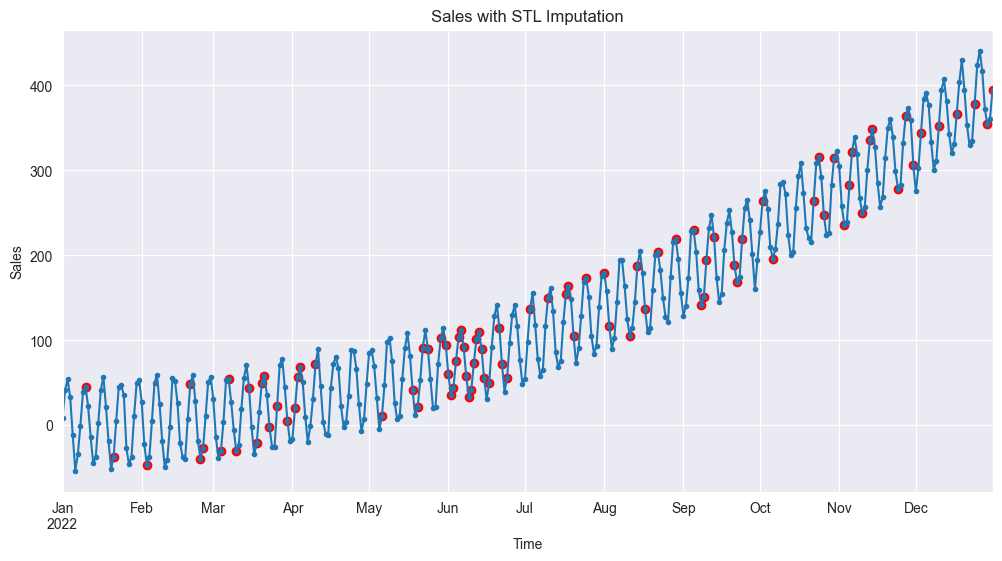

In [23]:
# Plot the series using pandas
plt.figure(figsize=[12, 6])
df_copy['sales'].plot(style='.-',  label='Sales')
plt.scatter(imputed_indices, df_copy.loc[imputed_indices, 'sales'], color='red')

plt.title("Sales with STL Imputation")
plt.ylabel("Sales")
plt.xlabel("Time")
plt.show()

## Multivariate feature imputation - Multivariate imputation by chained equations (MICE)
A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion. It performns multiple regressions over random sample ofthe data, then takes the average ofthe multiple regression values and uses that value to impute the missing value. In sklearn, it is implemented as follows:

In [36]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import xgboost

In [38]:
lr = LinearRegression()
lr1 =xgboost.XGBRegressor()

df_new = df.copy(deep = True)
imputer = IterativeImputer(estimator = lr1, max_iter=10, random_state=0)

df_new['sales'] = imputer.fit_transform(df_new[['sales']])


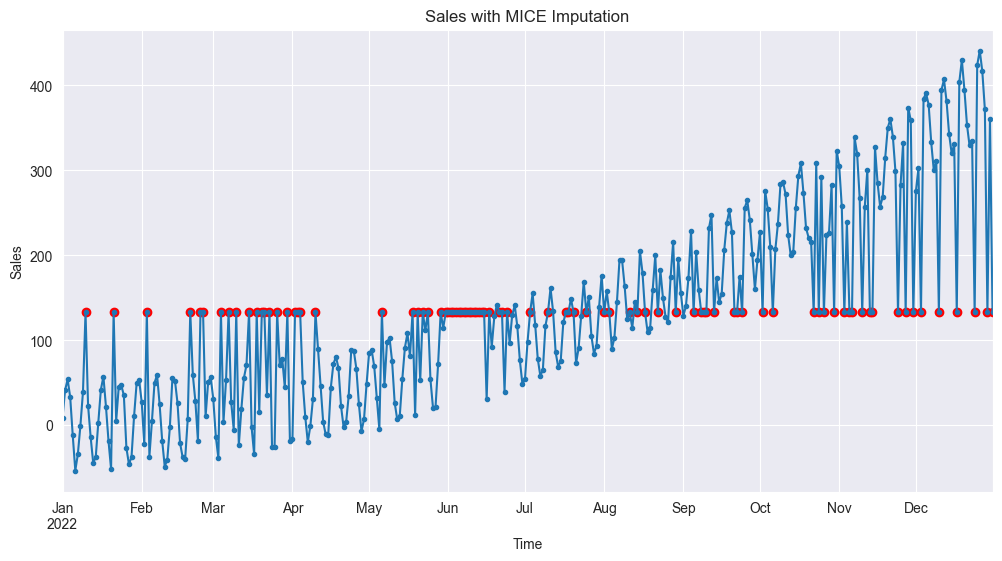

In [39]:
plt.figure(figsize=[12, 6])
df_new['sales'].plot(style='.-',  label='Sales')
plt.scatter(imputed_indices, df_new.loc[imputed_indices, 'sales'], color='red')

plt.title("Sales with MICE Imputation")
plt.ylabel("Sales")
plt.xlabel("Time")
plt.show()

## Xgboost imputation
- X_train: columns with non-missing data
- Y_train: column with missing data
This method uses other features to impute missing data

In [48]:
from xgboost import XGBRegressor

In [55]:
# Imputation function using XGBoost
def impute_with_xgboost(data):
    data_copy = data.copy()

    for column in data_copy.columns:
        if data[column].isnull().sum() > 0:
            print(f"Imputing column: {column}")
            
            non_missing = data_copy.loc[data[column].notna()]
            missing = data_copy.loc[data[column].isna()]
            
            X_train = non_missing.drop(columns=[column])
            y_train = non_missing[column]
            X_missing = missing.drop(columns=[column])
            
            if data[column].dtype == np.float64 or data[column].dtype == np.int64:
                model = XGBRegressor(n_estimators=100, random_state=42)
            else:
                model = XGBClassifier(n_estimators=100, random_state=42)
            
            model.fit(X_train, y_train)
            predictions = model.predict(X_missing)
            data_copy.loc[data[column].isna(), column] = predictions
    
    return data_copy


In [56]:
df_xgboost_imputed = impute_with_xgboost(df)


Imputing column: sales
             ad_spent
date                 
2022-01-01   6.593897
2022-01-02   2.503652
2022-01-03   0.000000
2022-01-04   0.000000
2022-01-05   0.000000
...               ...
2022-12-25  73.171310
2022-12-26  40.142687
2022-12-27  56.681980
2022-12-28  46.374554
2022-12-30  96.465107

[277 rows x 1 columns]


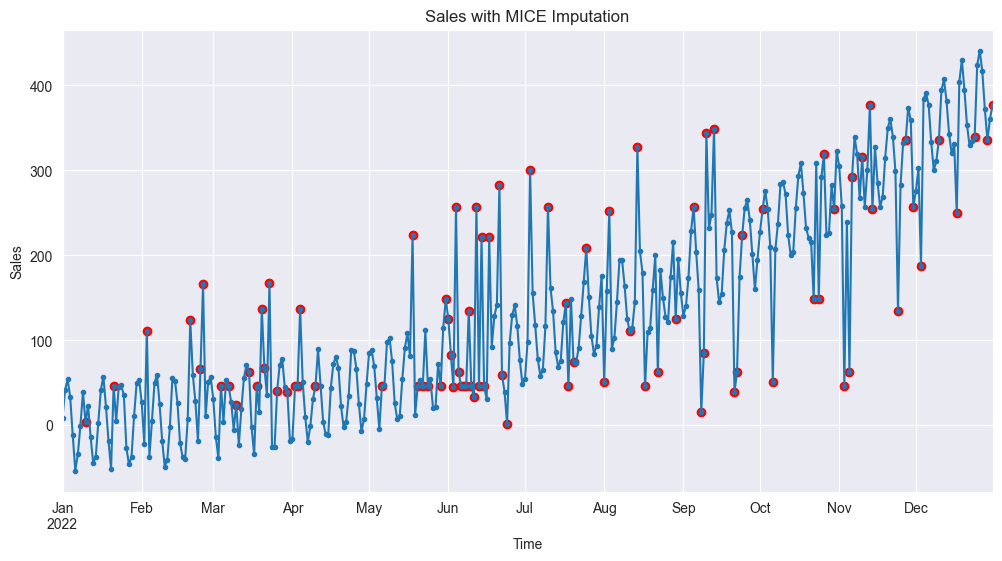

In [52]:
plt.figure(figsize=[12, 6])
df_xgboost_imputed['sales'].plot(style='.-',  label='Sales')
plt.scatter(imputed_indices, df_xgboost_imputed.loc[imputed_indices, 'sales'], color='red')

plt.title("Sales with MICE Imputation")
plt.ylabel("Sales")
plt.xlabel("Time")
plt.show()

In [58]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import xgboost

df_xgboost_imputed1=df.copy()

#setting up the imputer

imp = IterativeImputer(
    estimator=xgboost.XGBRegressor(
        n_estimators=5,
        random_state=1
        #tree_method='gpu_hist',
    ),
    missing_values=np.nan,
    max_iter=5,
    initial_strategy='mean',
    imputation_order='ascending',
    verbose=2,
    random_state=1
)

df_xgboost_imputed1[:] = imp.fit_transform(df_xgboost_imputed1)
df_xgboost_imputed1

[IterativeImputer] Completing matrix with shape (365, 2)
[IterativeImputer] Ending imputation round 1/5, elapsed time 0.05
[IterativeImputer] Change: 161.72127488031066, scaled tolerance: 0.4409888422903991 
[IterativeImputer] Ending imputation round 2/5, elapsed time 0.08
[IterativeImputer] Change: 0.0, scaled tolerance: 0.4409888422903991 
[IterativeImputer] Early stopping criterion reached.


,sales,ad_spent
date,,
2022-01-01,8.830262,6.593897
2022-01-02,41.116283,2.503652
2022-01-03,53.683909,0.000000
2022-01-04,32.968355,0.000000
2022-01-05,-12.254839,0.000000
...,...,...
2022-12-27,416.487041,56.681980
2022-12-28,371.791128,46.374554
2022-12-29,294.387238,107.609817


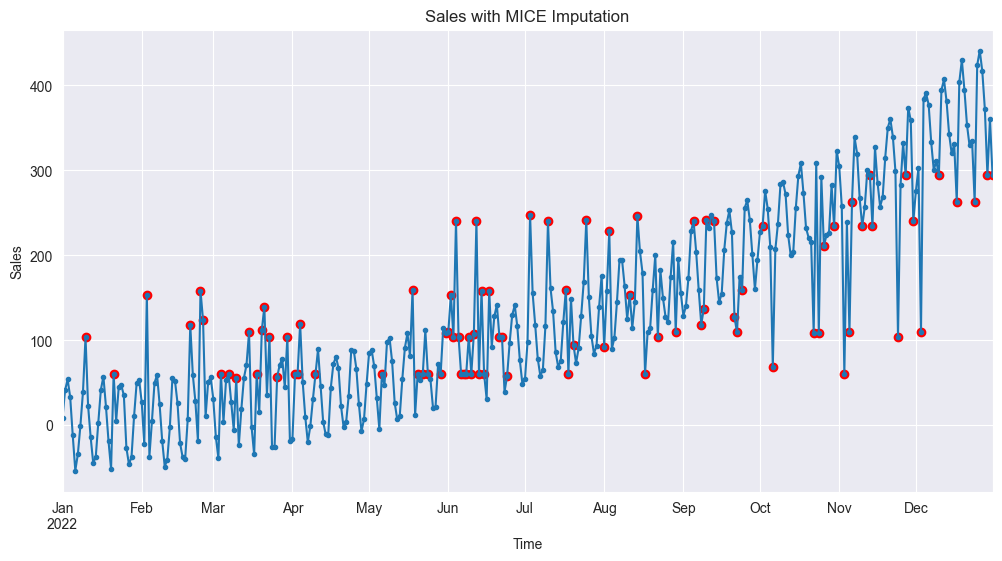

In [59]:
plt.figure(figsize=[12, 6])
df_xgboost_imputed1['sales'].plot(style='.-',  label='Sales')
plt.scatter(imputed_indices, df_xgboost_imputed1.loc[imputed_indices, 'sales'], color='red')

plt.title("Sales with MICE Imputation")
plt.ylabel("Sales")
plt.xlabel("Time")
plt.show()